# Generative Adversarial Models for Extreme Geospatial Downscaling

[![GitHub](https://img.shields.io/badge/GitHub-LAG_Climate-white.svg)](https://github.com/LiGuiye/LAG_Climate) [![Paper](https://img.shields.io/badge/Paper-arxiv.2402.14049-B31B1B.svg)](https://arxiv.org/abs/2402.14049)


In [ ]:
#@title Install LAG_Climate from GitHub
!pip install git+https://github.com/LiGuiye/LAG_Climate.git >> out.txt

In [ ]:
# @title Import Libraries and functions for plotting
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from data.config import get_dataset_path
from nets.dataset import get_dataset
from nets.models import Generator
from utils.utils import set_random_seed, get_config_from_json, upscale, normalize, downscale


def load_dataset(args):
    (path_train, path_test, train_mean, train_std) = get_dataset_path(args.data_name)
    args.train_mean = [float(i) for i in train_mean.split(',')]
    args.train_std = [float(i) for i in train_std.split(',')]
    dataset_test = get_dataset(path_test, args.data_size, args.train_mean, args.train_std)
    return dataset_test, args


def load_gen(args, curr_scale, device = torch.device("cuda")):
    g_ema = Generator(
        args.channel,
        args.noise_dim,
        kernelSize=args.kernelSize,
        residual_blocks=args.residual_blocks,
        residual_scaling=args.residual_scaling
    ).to(device)
    checkpoint = torch.load(f"{args.expid}/checkpoint/LAG_scale_{curr_scale}.pt", map_location=device)#, weights_only=True)
    g_ema.load_state_dict(checkpoint['gen_ema_state_dict'])
    return g_ema


def pred_img(args, dataset, idx:list, curr_scale:int, model, ncand:int=3, forceCPU:bool=True):
    samples_list = [dataset[i] for i in idx]
    hires = torch.stack(samples_list).to(torch.device("cuda"))
    lores = upscale(hires, args.max_scale)
    hires = upscale(hires, args.max_scale // curr_scale)

    n, _, h, w = lores.shape
    eps_size = [n, args.noise_dim, h, w]

    with torch.no_grad():
        fake = torch.cat(
            [
                model(
                    lores,
                    torch.normal(
                        mean=0,
                        std=y / (ncand - 1) if ncand > 1 else 0,
                        size=eps_size,
                        device=torch.device("cuda")
                    ),
                    curr_scale, 1
                )
                for y in range(ncand)
            ],
            dim=3
        )

    # stretch to origianl data range
    hires = normalize(hires, args.train_mean, args.train_std, True)
    lores = upscale(hires, curr_scale)
    fake = normalize(fake, args.train_mean, args.train_std, True)

    prepReturn = lambda x: x.cpu().squeeze() if forceCPU else x.squeeze()

    return prepReturn(hires), prepReturn(lores), prepReturn(fake)


def plot_preds(args, g_ema, dataset, curr_scale:int, idx:list=[0], ncand:int=3):
    assert len(idx) < 2, 'one image at a time'
    color_map = 'viridis' if args.data_name == 'Wind' else 'inferno'
    set_random_seed(666)

    # generate fake images
    hires, lores, fake = pred_img(args, dataset, idx, curr_scale, g_ema, ncand)

    subplot_size = 6
    images_num = ncand + 2  # ncand + LR + GT
    fontsize, fontsize_xlab = 30, 30
    rows, cols = args.channel, images_num + 1  # colorbar
    image_size = 8*curr_scale # start from 8x8

    fig = plt.figure(figsize=(cols * subplot_size, rows * subplot_size))
    gs = gridspec.GridSpec(
        rows,
        cols,
        width_ratios=[1 for _ in range(images_num)] + [0.05],
        height_ratios=[1 for _ in range(args.channel)]
    )

    for c in range(args.channel):
        if args.data_name == 'Wind':
            unit = '$m/s$'
            ylab = 'V' if c else 'U'
        else:
            unit = '$W/m^2$'
            ylab ='DHI' if c else 'DNI'

        vmin0, vmax0 = (hires[c, :].min(), hires[c, :].max())

        # input lr
        ax_lr = fig.add_subplot(gs[c, 0])
        ax_lr.imshow(lores[c, :], vmin=vmin0, vmax=vmax0, cmap=color_map)
        ax_lr.set_ylabel(ylab, fontsize=fontsize_xlab)

        # model outputs
        for s in range(ncand):
            ax = fig.add_subplot(gs[c, s + 1])
            ax.imshow(
                fake[c, :, image_size * s: image_size * (s + 1)],
                vmin=vmin0,
                vmax=vmax0,
                cmap=color_map
            )
            ax.set(xticks=[], yticks=[])
            if c == 0:
                ax.set_title("$z\sim\mathcal{N}(0,"+str(int((s/(ncand-1))**2))+")$",
                    fontsize=fontsize
                )

        # ground truth
        ax_hr = fig.add_subplot(gs[c, images_num - 1])
        im = ax_hr.imshow(hires[c, :], vmin=vmin0, vmax=vmax0, cmap=color_map)

        # colorbar
        cbar = fig.colorbar(im, cax=fig.add_subplot(gs[c, images_num]))
        cbar.ax.tick_params(labelsize=fontsize_xlab, length=10)
        for t in cbar.ax.get_yticklabels():
            t.set_horizontalalignment('right')
            t.set_x(4)
        cbar.set_label(label=unit, size=fontsize_xlab)

        # set axis
        ax_lr.set(xticks=[], yticks=[])
        ax_hr.set(xticks=[], yticks=[])

        # set titles
        if c == 0:
            ax_lr.set_title('LR', fontsize=fontsize)
            ax_hr.set_title('Ground Truth', {'fontsize': fontsize})
    plt.subplots_adjust(wspace=0, hspace=0.2, right=0.8)
    fig.tight_layout()

def plot_preds_samples(args, g_ema, dataset, curr_scale:int, std:float=1.0, sample_num:int=50, plot_samples:int=3, idx:list=[0]):
    """
    Plot several samples as well the mean and std of model predictions for a single test image.
    """
    assert len(idx) < 2, 'one test image at a time'
    assert sample_num >= plot_samples, 'sample_num should be greater or equal to plot_samples'
    color_map = 'viridis' if args.data_name == 'Wind' else 'inferno'
    set_random_seed(666)

    # load data
    device=torch.device("cuda")
    samples_list = [dataset[i] for i in idx]
    x = torch.stack(samples_list).to(device)
    lores = upscale(x, args.max_scale)
    hires = upscale(x, args.max_scale // curr_scale)
    hires = normalize(hires, args.train_mean, args.train_std, True).cpu().squeeze()

    # generate fake samples
    n, _, h, w = lores.shape
    eps_size = [n, args.noise_dim, h, w]
    fake = torch.empty((sample_num, args.channel, h * curr_scale, w * curr_scale))
    with torch.no_grad():
        for i in range(sample_num):
            fake[i] = g_ema(lores, torch.normal(0, std, eps_size, device=device), curr_scale, 1)
            fake[i] = normalize(fake[i], args.train_mean, args.train_std, True) # back2raw
    lores = downscale(upscale(hires, curr_scale), curr_scale).cpu().squeeze()

    # plot
    subplot_size = 6
    images_num = 4+plot_samples  # LR + 3 samples + mean + std + GT
    rows, cols = args.channel, images_num + 1  # colorbar
    fontsize, fontsize_xlab = 30, 30

    fig = plt.figure(figsize=(cols * subplot_size, rows * subplot_size))
    gs = gridspec.GridSpec(rows, cols,
        width_ratios=[1 for _ in range(images_num)] + [0.05],
        height_ratios=[1 for _ in range(args.channel)]
    )

    for c in range(args.channel):
        if args.data_name == 'Wind':
            unit = '$m/s$'
            ylab = 'V' if c else 'U'
        else:
            unit = '$W/m^2$'
            ylab ='DHI' if c else 'DNI'

        vmin0, vmax0 = (hires[c, :].min(), hires[c, :].max())

        # real_lr
        ax_lr = fig.add_subplot(gs[c, 0])
        ax_lr.imshow(lores[c, :], vmin=vmin0, vmax=vmax0, cmap=color_map)
        ax_lr.set_ylabel(ylab, fontsize=fontsize_xlab)

        for i in range(plot_samples):
            ax = fig.add_subplot(gs[c, i + 1])
            ax.imshow(fake[i, c, :, :], vmin=vmin0, vmax=vmax0, cmap=color_map)
            ax.set(xticks=[], yticks=[])
            if c == 0:
                ax.set_title(f"Sample {i+1}", fontsize=fontsize)

        ax_mean = fig.add_subplot(gs[c, 1+plot_samples])
        ax_mean.imshow(
            fake[:, c, :, :].mean(0),
            vmin=vmin0,
            vmax=vmax0,
            cmap=color_map
        )

        ax_std = fig.add_subplot(gs[c, 2+plot_samples])
        ax_std.imshow(fake[:, c, :, :].std(0), cmap="gray")

        # real_hr
        ax_hr = fig.add_subplot(gs[c, 3+plot_samples])
        im = ax_hr.imshow(hires[c, :], vmin=vmin0, vmax=vmax0, cmap=color_map)

        # colorbar
        cbar = fig.colorbar(im, cax=fig.add_subplot(gs[c, images_num]))
        cbar.ax.tick_params(labelsize=fontsize_xlab, length=10)
        for t in cbar.ax.get_yticklabels():
            t.set_horizontalalignment('right')
            t.set_x(4)
        cbar.set_label(label=unit, size=fontsize_xlab)

        # set axis
        ax_lr.set(xticks=[], yticks=[])
        ax_mean.set(xticks=[], yticks=[])
        ax_std.set(xticks=[], yticks=[])
        ax_hr.set(xticks=[], yticks=[])

        # set titles
        if c == 0:
            ax_lr.set_title('LR', fontsize=fontsize)
            ax_mean.set_title("Mean", fontsize=fontsize)
            ax_std.set_title("Standard deviation", fontsize=fontsize)
            ax_hr.set_title('Ground Truth', {'fontsize': fontsize})
    plt.subplots_adjust(wspace=0, hspace=0.2, right=0.8)
    fig.tight_layout()

def plot_preds_allScales(args, dataset, idx:list=[0]):
    """
    Plot the predictions at all scales for a single test image.
    """
    assert len(idx) < 2, 'one test image at a time'
    color_map = 'viridis' if args.data_name == 'Wind' else 'inferno'

    fake_list = []
    for scale in [4, 8, 16, 32, 64]:
        hires, lores, fake = pred_img(args, dataset, idx, scale, load_gen(args, scale), ncand=1)
        fake_list.append(fake)
    lores, hires = lores.cpu().squeeze(), hires.cpu().squeeze()

    subplot_size = 6
    images_num = 7  # LR + 4x + 8x + 16x + 32x + 64x + GT
    rows, cols = args.channel, images_num + 1  # colorbar
    fontsize, fontsize_xlab = 30, 30

    fig = plt.figure(figsize=(cols * subplot_size, rows * subplot_size))
    gs = gridspec.GridSpec(rows, cols,
        width_ratios=[1 for _ in range(images_num)] + [0.05],
        height_ratios=[1 for _ in range(args.channel)]
    )

    for c in range(args.channel):
        if args.data_name == 'Wind':
            unit = '$m/s$'
            ylab = 'V' if c else 'U'
        else:
            unit = '$W/m^2$'
            ylab ='DHI' if c else 'DNI'

        vmin0, vmax0 = (hires[c, :].min(), hires[c, :].max())

        # real_lr
        ax_lr = fig.add_subplot(gs[c, 0])
        ax_lr.imshow(lores[c, :], vmin=vmin0, vmax=vmax0, cmap=color_map)
        ax_lr.set_ylabel(ylab, fontsize=fontsize_xlab)

        # model outputs
        for s, scale_title in enumerate([r"$4\times$ SR", r"$8\times$ SR", r"$16\times$ SR", r"$32\times$ SR", r"$64\times$ SR"]):
            ax = fig.add_subplot(gs[c, s + 1])
            ax.imshow(
                fake_list[s][c, :, :],
                vmin=vmin0,
                vmax=vmax0,
                cmap=color_map
            )
            ax.set(xticks=[], yticks=[])
            if c == 0:
                ax.set_title(scale_title, fontsize=fontsize)

        # real_hr
        ax_hr = fig.add_subplot(gs[c, images_num - 1])
        im = ax_hr.imshow(hires[c, :], vmin=vmin0, vmax=vmax0, cmap=color_map)

        # colorbar
        cbar = fig.colorbar(im, cax=fig.add_subplot(gs[c, images_num]))
        cbar.ax.tick_params(labelsize=fontsize_xlab, length=10)
        for t in cbar.ax.get_yticklabels():
            t.set_horizontalalignment('right')
            t.set_x(4)
        cbar.set_label(label=unit, size=fontsize_xlab)

        # set axis
        ax_lr.set(xticks=[], yticks=[])
        ax_hr.set(xticks=[], yticks=[])

        # set titles
        if c == 0:
            ax_lr.set_title('LR', fontsize=fontsize)
            ax_hr.set_title('Ground Truth', fontsize=fontsize)

    fig.tight_layout()

In [2]:
folder = {
    "Wind": "results/Wind/Wind_bs32_epoch20_lr3e-3_64X",
    "Solar":"results/Solar/Solar_bs1_epoch15_lr4e-3_64X"
}

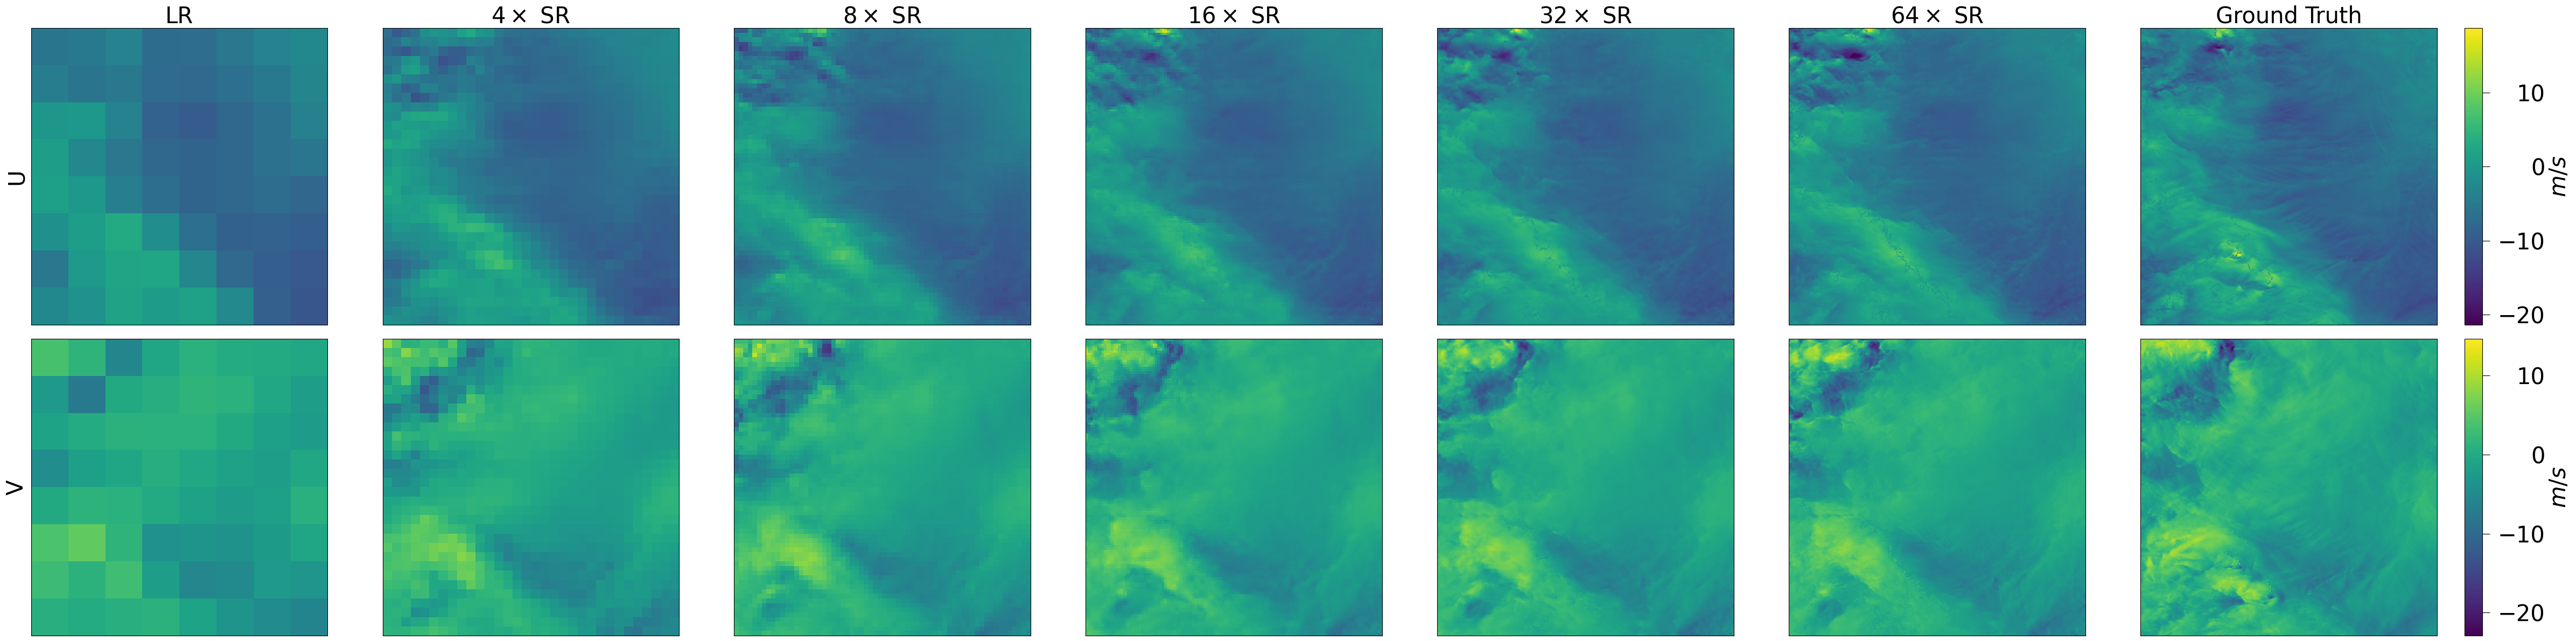

In [3]:
#@title Generate HR images at all downscaling scales
data_type = "Wind" # @param ["Wind","Solar"]

args, _ = get_config_from_json(f"{folder[data_type]}/args/args.json")
dataset, args = load_dataset(args)
plot_preds_allScales(args, dataset)

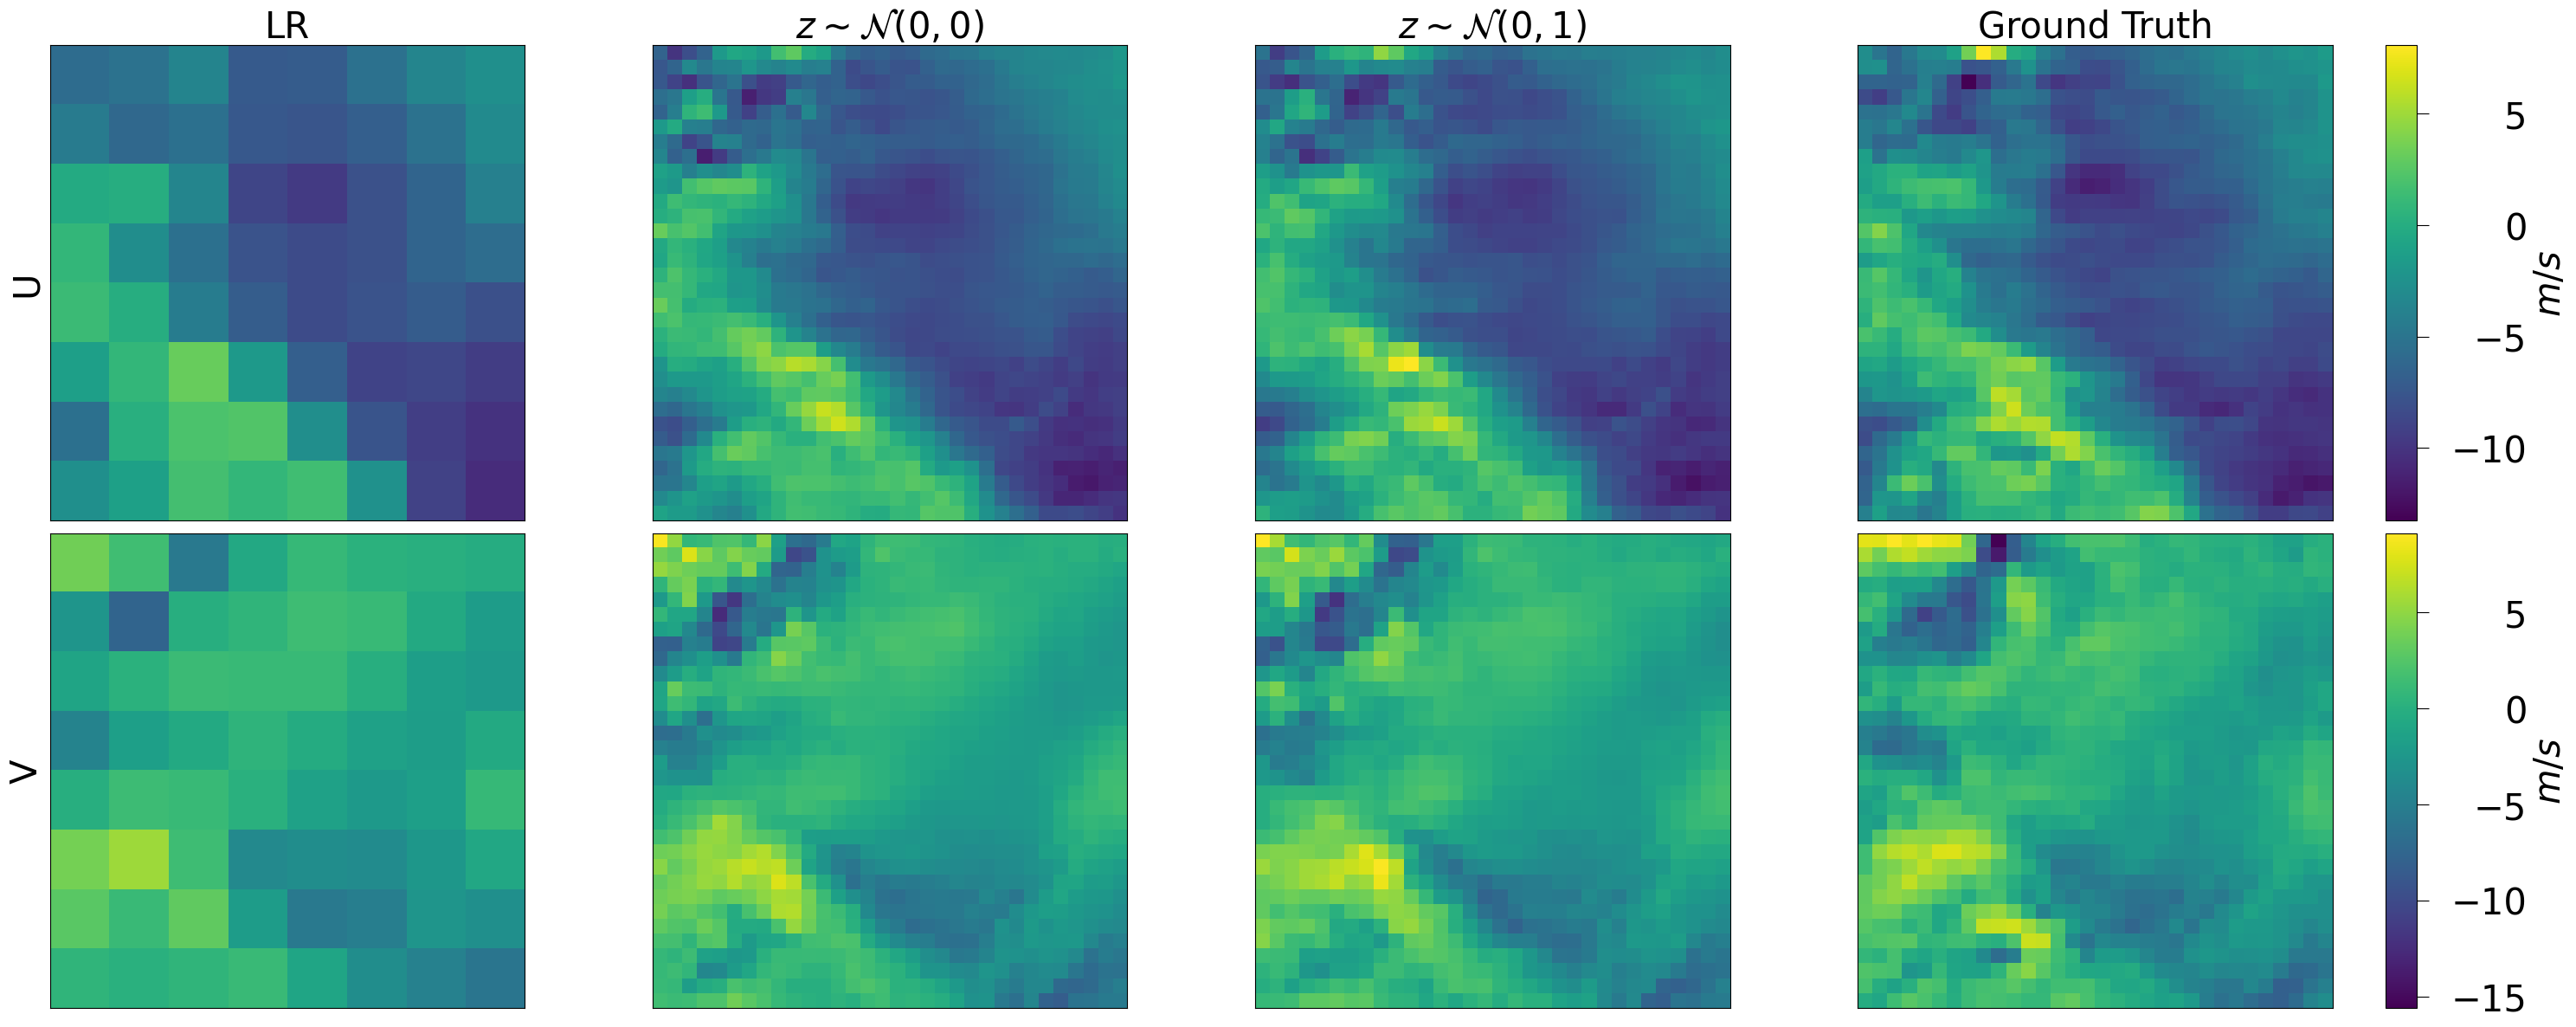

In [4]:
#@title Generate HR images from chosen downscaling scale and data type
data_type = "Wind" # @param ["Wind","Solar"]
test_scale = 4 # @param ["4","8","16","32","64"] {"type":"raw"}

args, _ = get_config_from_json(f"{folder[data_type]}/args/args.json")
dataset, args = load_dataset(args)
g_ema = load_gen(args, test_scale)
plot_preds(args, g_ema, dataset, test_scale, ncand=2)

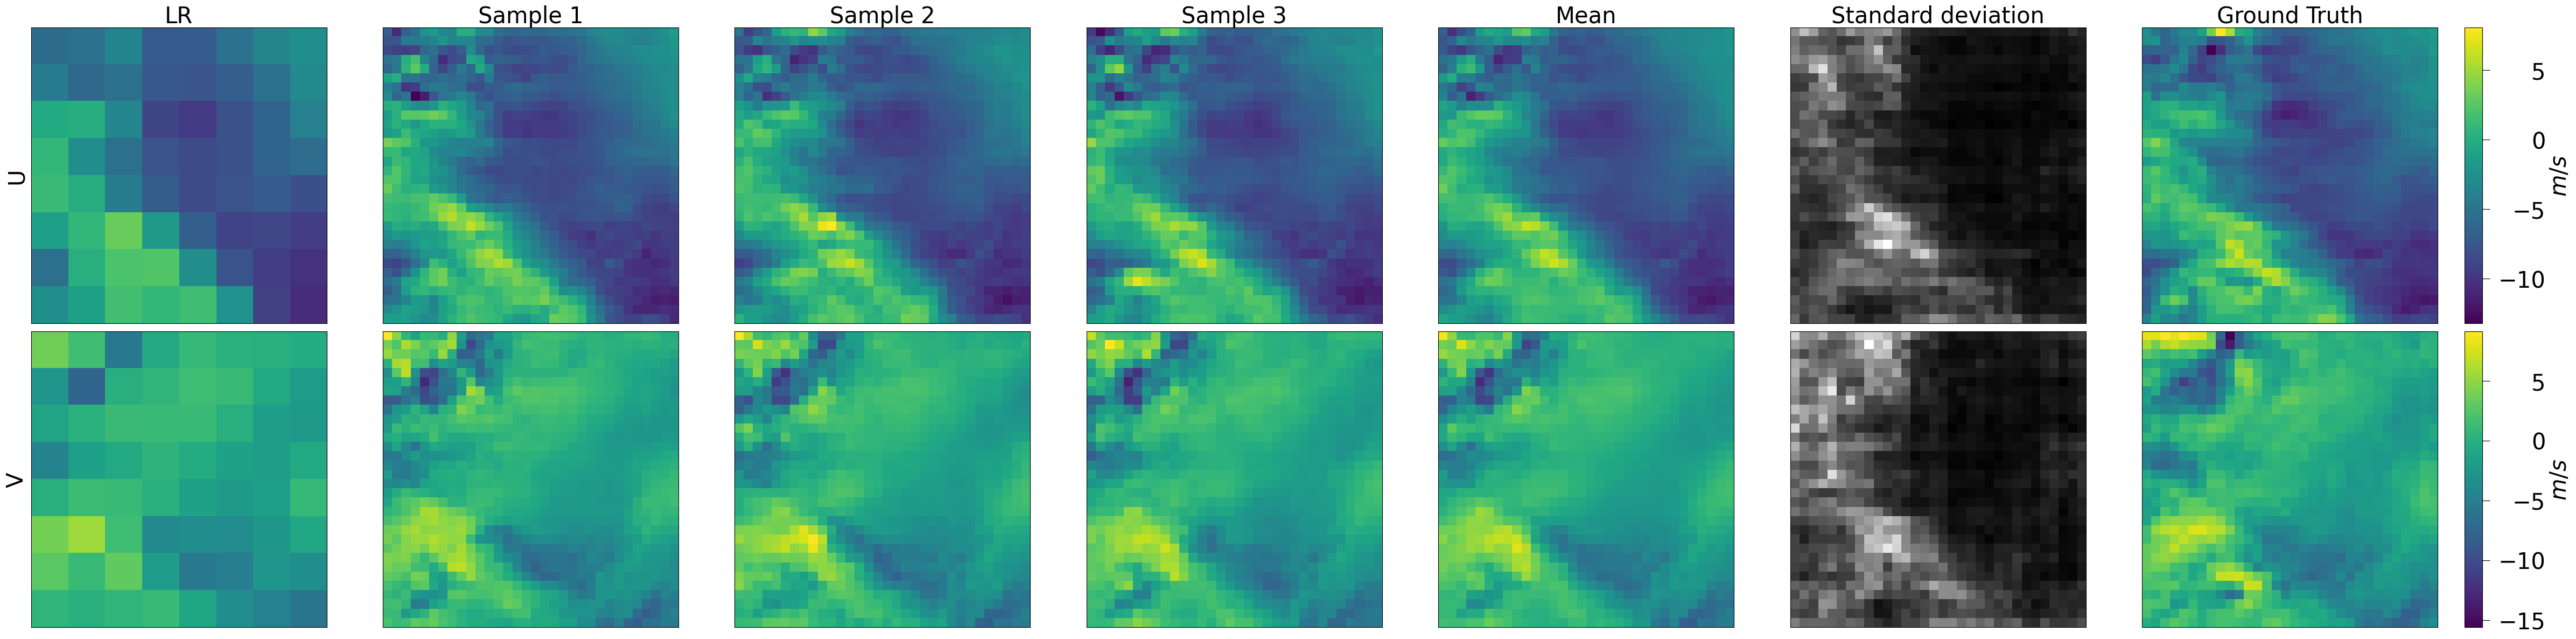

In [8]:
#@title Sample images from chosen downscaling scale and data type
data_type = "Wind" # @param ["Wind","Solar"]
test_scale = 4 # @param ["4","8","16","32","64"] {"type":"raw"}
noise_std = 1.0 # @param {"type":"number", "placeholder":"1.0"}
num_samples = 50 # @param {"type":"integer", "placeholder":"50"}
num_plot_samples = 3 # @param {"type":"integer", "placeholder":"3"}

plot_preds_samples(args, g_ema, dataset, test_scale, noise_std, num_samples, num_plot_samples)